# Test Fourier transform

Test of classification of OCT images based on Forier transform analysis.

In [53]:
from src.image_OCT import *
from src.image_Quantification_3 import *
import math 
from sklearn import svm
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

dirname = os.getcwd()
print(dirname)
savefold=os.path.join(dirname, 'Data\Figure\\') # "C:/Users/csoub/OneDrive/Bureau/3A/Ensta/Super projet/Algo_Maelle/Data/Figure/"
extension=".png"
%matplotlib inline

c:\Users\csoub\OneDrive\Bureau\3A\Ensta\Super projet\Quantification_of_corneal_surgery_antecedent


In [54]:
filepathname_haze1=os.path.join(dirname, 'Data','HAZE','haze 1.jpg')
filepathname_haze2=os.path.join(dirname, 'Data','HAZE','haze 3.jpg')
filepathname_healthy1=os.path.join(dirname, 'Data','Healthy','23923_BOULIS_OD.jpg')
filepathname_healthy2=os.path.join(dirname, 'Data','VILBERT_Maelle','test.jpg')
filepathname_fuchs1=os.path.join(dirname, 'Data','Fuchs_2','VANLUD_OD_6_Line.jpg')
# filepathname_fuchs2=os.path.join(dirname, 'Data','Fuchs_2','FAIJEA_OS_1_Line.jpg')
filepathname_fuchs2=os.path.join(dirname, 'Data','Fuchs_2','SELNIC_OS_0_Line.jpg')

# filepathname=os.path.join(dirname, 'Data','Healthy','80608_REZAZK_OS.jpg')
test_ex=[filepathname_haze1,filepathname_haze2,filepathname_healthy1,filepathname_healthy2,filepathname_fuchs1,filepathname_fuchs2]
test_type=["haze1","haze2","healthy1","healthy2","fuchs1",'fuchs2']

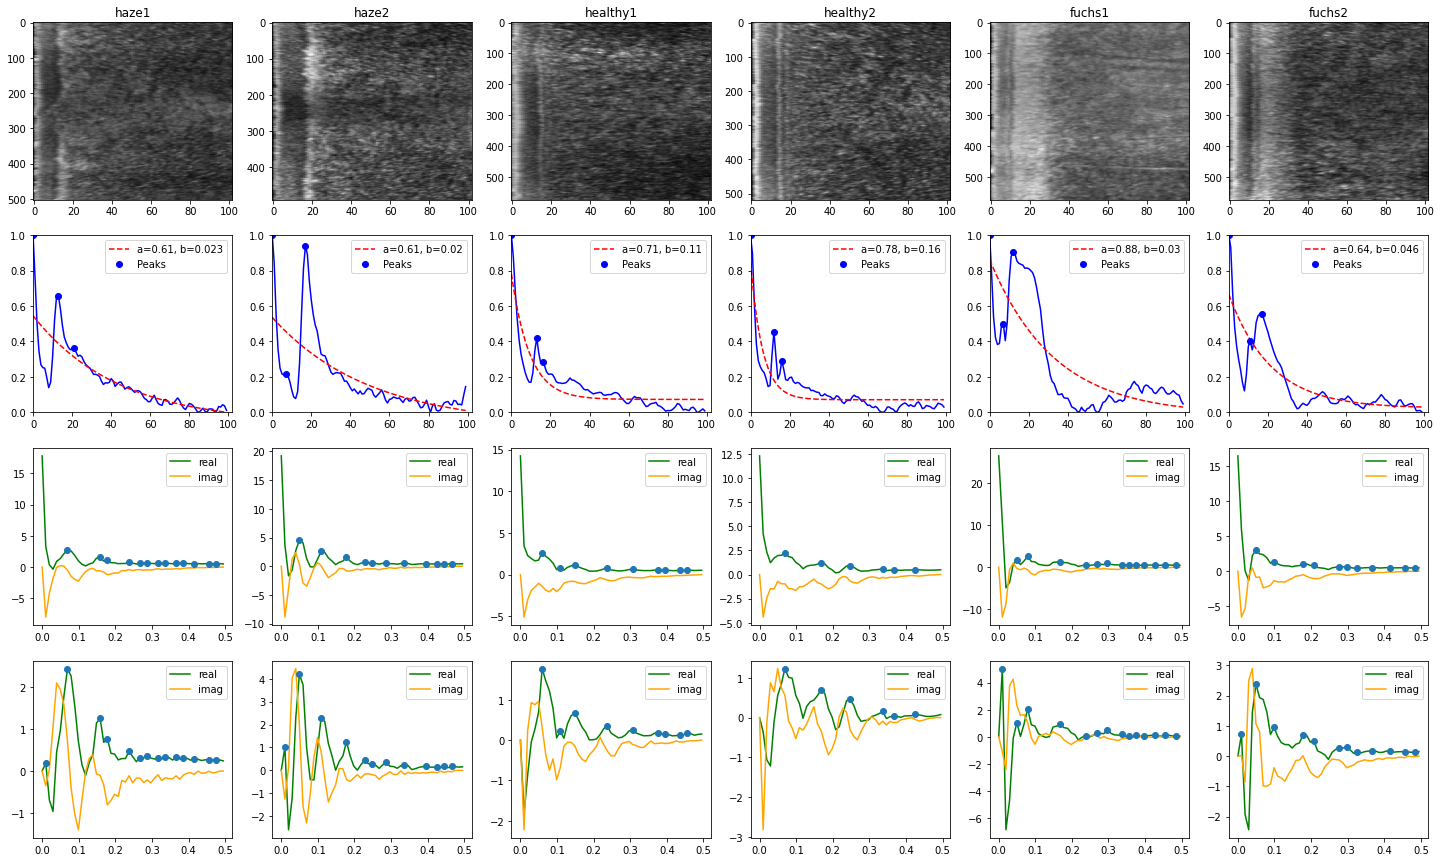

In [55]:
n=len(test_ex)
fig,ax=plt.subplots(4,n,figsize=(25,15))
move=False;eliminate=30;useExpCorr=False
for i,filepathname in enumerate(test_ex):
    name=test_type[i]
    im=image_OCT(filepathname)
    im.AutoTreatment()
    im_Q=image_Quantification_3(im,movingWin=False,eliminate=eliminate,useExpCorr=useExpCorr)
    ax[0][i].imshow((im_Q.image[im_Q.peaks[0]-im_Q.pre_window:im_Q.peaks[0]+im_Q.post_window][:]).T,aspect="auto",cmap="gray")
    ax[0][i].set_title(name)
    ax[1][i].plot(im_Q.iProfileCrop,'b')
    ax[1][i].plot(im_Q.iProfileExp,'r--',label="a={:.2}, b={:.2}".format(im_Q.Alpha,im_Q.Beta))
    ax[1][i].plot(im_Q.peaks-im_Q.xmin,im_Q.iProfileCrop[im_Q.peaks-im_Q.xmin],"bo",label="Peaks")
    ax[1][i].legend()
    ax[1][i].set_xlim([0,im_Q.pre_window+im_Q.post_window])
    ax[1][i].set_ylim([0,1])
    y = np.fft.fft(im_Q.iProfileCrop)
    # y = np.fft.fft(im_Q.iProfileExpCorrection)
    dt=1
    y = dt*np.fft.fftshift(np.append(y,y[0]))
    n = y.size
    freq = np.fft.fftshift(np.fft.fftfreq(n, d=dt))
    y=y[n//2:];freq=freq[n//2:]
    ax[2][i].plot(freq,np.real(y),'g',label="real")
    ax[2][i].plot(freq,np.imag(y),'orange',label="imag")
    fq=argrelextrema(y, np.greater)[0]
    ax[2][i].plot(freq[fq],y[fq],'o')
    ax[2][i].legend()
    y = np.fft.fft(im_Q.iProfileExpCorrection)
    # y = np.fft.fft(im_Q.iProfileExpCorrection)
    dt=1
    y = dt*np.fft.fftshift(np.append(y,y[0]))
    n = y.size
    freq = np.fft.fftshift(np.fft.fftfreq(n, d=dt))
    y=y[n//2:];freq=freq[n//2:]
    ax[3][i].plot(freq,np.real(y),'g',label="real")
    ax[3][i].plot(freq,np.imag(y),'orange',label="imag")
    fq=argrelextrema(y, np.greater)[0]
    ax[3][i].plot(freq[fq],y[fq],'o')
    ax[3][i].legend()
plt.show()

## Test sur tout le profil spectral 
Première approche se basant sur l'exploitation de toute le profil profile (discret). 
On propose plusieurs approche:
- Explotation tel quel
- Utilisation d'une PCA pour réduire la dimension

In [56]:
def sp(y):
    y = np.fft.fft(y)
    # y = np.fft.fft(im_Q.iProfileExpCorrection)
    dt=1
    y = dt*np.fft.fftshift(np.append(y,y[0]))
    n = y.size
    freq = np.fft.fftshift(np.fft.fftfreq(n, d=dt))
    y=y[n//2:];freq=freq[n//2:]
    return(y)

def create_dataset_tf_full(repository,healthy_value,movingWin=False,eliminate=0,useExpCorr=False):
	files = [f for f in listdir(repository) if isfile(join(repository, f))]
	quantification=[]
	i=0
	i_list=[]
	for f in files:
		if(f[-3:]=="jpg"):
			i+=1
			try:
				im=image_OCT(os.path.join(repository, f))
			except:
				print("Error creating: "+f+" image #"+str(i))
			try:
				im.AutoTreatment()
				im_Q=image_Quantification_3(im,movingWin=movingWin,eliminate=eliminate,useExpCorr=useExpCorr)
				I=np.real(sp(im_Q.iProfileCrop))
				# im_Q=image_Quantification_2(im,plot=False,intensity_corr=intensity_corr)
				parameters=dict(enumerate(I))
				parameters["Healthy"]=healthy_value
				parameters["Origin"]=f[:-4]
				quantification.append(parameters)
				# print(i,":",healthy)
				i_list.append(i)
			except:
				print("Error with treatment of: "+f+" image #"+str(i))
	n=len(quantification)
	print(n,"/",len(files)," files succesfully quantified")
	data=pd.DataFrame(quantification,index=range(n)) 
	return(data)


In [57]:
# Compute or import dataset
move=True
useExpCorr=False
# folder="exp_correction/"
# append="_mov_win-exp_corr_"
append="_full_"
folder=""

try:
	data_healthy = pd.read_pickle("./Dataset/"+folder+"data_set_TF_healthy"+append+".pkl")
except:
	repertory_healthy=os.path.join(dirname, 'Data','Healthy')
	healthy_value=1 #healthy
	data_healthy=create_dataset_tf_full(repertory_healthy,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_healthy.to_pickle("./Dataset/data_set_TF_healthy"+append+".pkl")
 
try:
	data_healthy_2 = pd.read_pickle("./Dataset/"+folder+"data_set_TF_healthy_2"+append+".pkl")
except:
	repertory_healthy_2=os.path.join(dirname, 'Data','Healthy_2')
	healthy_value=1 #healthy
	data_healthy_2=create_dataset_tf_full(repertory_healthy_2,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_healthy_2.to_pickle("./Dataset/data_set_TF_healthy_2"+append+".pkl")
try:
	data_haze = pd.read_pickle("./Dataset/"+folder+"data_set_TF_haze"+append+".pkl")
except:
	repertory_haze=os.path.join(dirname, 'Data','HAZE')
	healthy_value=0 #patho
	data_haze=create_dataset_tf_full(repertory_haze,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_haze.to_pickle("./Dataset/data_set_TF_haze"+append+".pkl")

try:
	data_haze_2 = pd.read_pickle("./Dataset/"+folder+"data_set_TF_haze_2"+append+".pkl")
except:
	repertory_haze_2=os.path.join(dirname, 'Data','HAZE_2')
	healthy_value=0 #patho
	data_haze_2=create_dataset_tf_full(repertory_haze_2,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_haze_2.to_pickle("./Dataset/data_set_TF_haze_2"+append+".pkl")

try:
	data_fuchs = pd.read_pickle("./Dataset/"+folder+"data_set_TF_fuchs"+append+".pkl")
except:
	repertory_fuchs=os.path.join(dirname, 'Data','Fuchs_2')
	healthy_value=2 #fushs
	data_fuchs=create_dataset_tf_full(repertory_fuchs,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_fuchs.to_pickle("./Dataset/data_set_TF_fuchs"+append+".pkl")

try:
	data_fuchs_rep = pd.read_pickle("./Dataset/"+folder+"data_set_TF_fuchs_rep"+append+".pkl") 
except:
	repertory_fuchs_rep=os.path.join(dirname, 'Data','repetabilite_FuchsDMEK')
	healthy_value=2 #fushs
	data_fuchs_rep=create_dataset_tf_full(repertory_fuchs_rep,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_fuchs_rep.to_pickle("./Dataset/data_set_TF_fuchs_rep"+append+".pkl")

print("Succesfully imported")

Succesfully imported


In [58]:
data_healthy.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,Healthy,Origin
0,21.207481,6.756101,2.784957,1.194324,0.762096,0.279904,1.039662,1.513071,1.926395,1.277428,...,0.526678,0.599496,0.544028,0.509406,0.495367,0.528097,0.529516,0.522507,1,23923_BOULIS_OD
1,24.827077,7.376839,2.756656,0.632478,0.184993,0.497551,2.234868,1.406976,1.573745,1.138736,...,0.441532,0.482279,0.477468,0.406862,0.471756,0.456135,0.465652,0.498468,1,79296_BESNIC_OD
2,27.513528,7.502666,0.937002,0.602439,0.825292,0.279923,0.619189,1.958902,0.995671,1.032629,...,0.516351,0.578676,0.533646,0.475648,0.532982,0.539439,0.515894,0.510087,1,80552_CORANT_OD
3,21.750672,6.945797,1.647784,0.896028,0.029534,0.745766,1.369407,1.541572,1.386720,1.381515,...,0.523349,0.515384,0.509638,0.498745,0.512583,0.496277,0.511761,0.569064,1,80552_CORANT_OS
4,27.314791,7.712234,1.454544,0.350082,-0.264795,1.240551,1.497598,0.511853,1.705875,1.513931,...,0.486972,0.452175,0.444647,0.433545,0.438501,0.454514,0.469288,0.394925,1,80553_DUMFAU_OD


Text(0.5, 1.0, 'Fuchs, N=316')

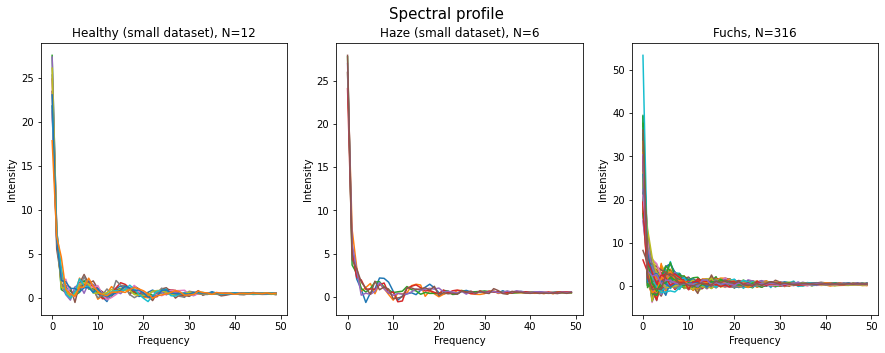

In [59]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
fig.suptitle("Spectral profile",size=15)

n=data_healthy.shape[0]
for i in range(n):
    ax[0].plot(data_healthy.iloc[i][0:50])
    ax[0].set_xlabel("Frequency")
    ax[0].set_ylabel("Intensity")
ax[0].set_title("Healthy (small dataset), N={:.0f}".format(data_healthy.shape[0]))

n=data_haze.shape[0]
for i in range(n):
    ax[1].plot(data_haze.iloc[i][0:50])
    ax[1].set_xlabel("Frequency")
    ax[1].set_ylabel("Intensity")
ax[1].set_title("Haze (small dataset), N={:.0f}".format(data_haze.shape[0]))
  
n=data_fuchs.shape[0]
for i in range(n):
    ax[2].plot(data_fuchs.iloc[i][0:50])
    ax[2].set_xlabel("Frequency")
    ax[2].set_ylabel("Intensity")
ax[2].set_title("Fuchs, N={:.0f}".format(data_fuchs.shape[0]))


Text(0.5, 1.0, 'Fuchs, N=316')

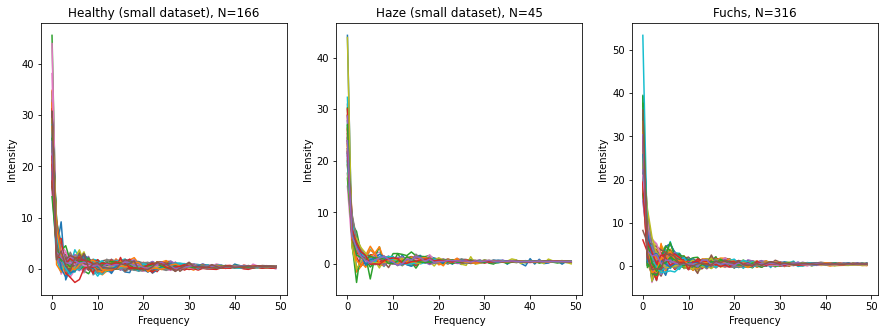

In [60]:
fig,ax=plt.subplots(1,3,figsize=(15,5))

n=data_healthy_2.shape[0]
for i in range(n):
    ax[0].plot(data_healthy_2.iloc[i][0:50])
    ax[0].set_xlabel("Frequency")
    ax[0].set_ylabel("Intensity")
ax[0].set_title("Healthy (small dataset), N={:.0f}".format(data_healthy_2.shape[0]))

n=data_haze_2.shape[0]
for i in range(n):
    ax[1].plot(data_haze_2.iloc[i][0:50])
    ax[1].set_xlabel("Frequency")
    ax[1].set_ylabel("Intensity")
ax[1].set_title("Haze (small dataset), N={:.0f}".format(data_haze_2.shape[0]))
  
n=data_fuchs.shape[0]
for i in range(n):
    ax[2].plot(data_fuchs.iloc[i][0:50])
    ax[2].set_xlabel("Frequency")
    ax[2].set_ylabel("Intensity")
ax[2].set_title("Fuchs, N={:.0f}".format(data_fuchs.shape[0]))

Text(0.5, 1.0, 'PCA result in terms of variance')

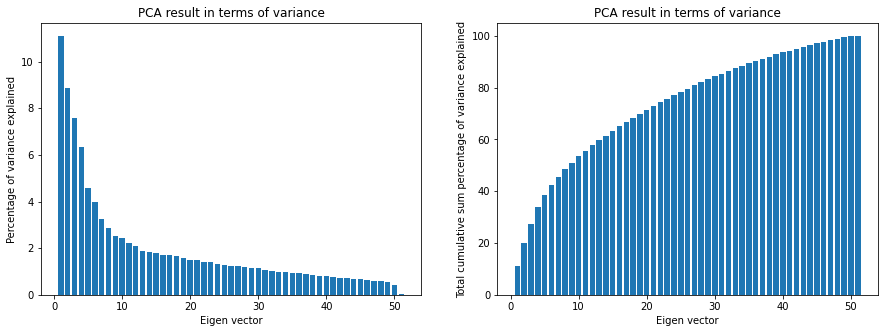

In [61]:
from sklearn.decomposition import PCA

data=pd.concat([data_healthy_2,data_fuchs,data_haze_2])
# data=pd.concat([data_healthy_2,data_fuchs])
# data=data_healthy
# data=pd.concat([data_healthy,data_haze])
# data
data_copy=data.drop(["Healthy","Origin"],axis=1)
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)
N=len(data_copy)
K=len(data_copy.columns)
pca = PCA()
pca.fit(data_copy)



fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].bar(np.arange(1,K+1,1),pca.explained_variance_ratio_*100)
ax[0].set_xlabel('Eigen vector')
ax[0].set_ylabel('Percentage of variance explained')
ax[0].set_title("PCA result in terms of variance")

ax[1].bar(np.arange(1,K+1,1),np.cumsum(pca.explained_variance_ratio_*100))
ax[1].set_xlabel('Eigen vector')
ax[1].set_ylabel('Total cumulative sum percentage of variance explained')
ax[1].set_title("PCA result in terms of variance")



We propose to use the 10 first axis

In [62]:
nb_axis=10
# new_data=data_copy@(pca.components_[0:nb_axis]).T
# new_data["Healthy"]=data["Healthy"]
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

ytrain_ref=train["Healthy"]
Xtrain_ref=train.drop(["Healthy","Origin"],axis=1)

ytest_ref=test["Healthy"]
Xtest_ref=test.drop(["Healthy","Origin"],axis=1)

print("Total number of data:{:.0f} splited in train:{:.0f} and test:{:.0f}".format(len(data),len(ytrain_ref),len(ytest_ref)))
print("		Number of healthy in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==1),(np.sum(data["Healthy"]==1)/len(data["Healthy"]==1)*100),np.sum(ytrain_ref==1),(np.sum(ytrain_ref==1)/len(ytrain_ref)*100),np.sum(ytest_ref==1),(np.sum(ytest_ref==1)/len(ytest_ref)*100)))
print("		Number of haze    in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==0),(np.sum(data["Healthy"]==0)/len(data["Healthy"]==0)*100),np.sum(ytrain_ref==0),(np.sum(ytrain_ref==0)/len(ytrain_ref)*100),np.sum(ytest_ref==0),(np.sum(ytest_ref==0)/len(ytest_ref)*100)))
print("		Number of fuchs   in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==2),(np.sum(data["Healthy"]==2)/len(data["Healthy"]==2)*100),np.sum(ytrain_ref==2),(np.sum(ytrain_ref==2)/len(ytrain_ref)*100),np.sum(ytest_ref==2),(np.sum(ytest_ref==2)/len(ytest_ref)*100)))
ytrain_ref=(ytrain_ref==1)*1
ytest_ref=(ytest_ref==1)*1
# ytest["Healthy"]=(ytest["Healthy"]==1)*1
# new_data["Healthy"]=data["Healthy"]

Total number of data:527 splited in train:421 and test:106
		Number of healthy in   dataset:166 (31%) train:124 (29%) test:42 (40%)
		Number of haze    in   dataset:45 (9%) train:39 (9%) test:6 (6%)
		Number of fuchs   in   dataset:316 (60%) train:258 (61%) test:58 (55%)


In [63]:
nb_axis=10
Xtrain=Xtrain_ref@(pca.components_[0:nb_axis]).T
Xtest=Xtest_ref@(pca.components_[0:nb_axis]).T
ytrain=ytrain_ref
ytest=ytest_ref

### SVM Classifier Healthy vs. sick

Accuracy: 60.4
Sensibility: 0.0
Specificity: 0.0


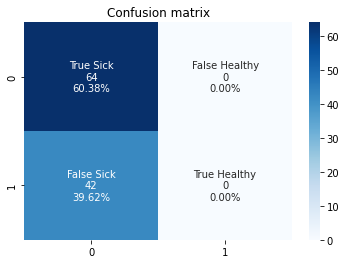

In [64]:
from sklearn import svm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

clf = svm.SVC()

# cv = KFold(n_splits=10, random_state=1, shuffle=True)
# scores = cross_val_score(clf, Xtrain, ytrain, scoring='accuracy', cv=cv, n_jobs=-1)
# print(scores)
clf.fit(Xtrain, ytrain)
ytest_pred = clf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_names = ['True Sick','False Healthy','False Sick','True Healthy']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix")

print("Accuracy: {:.1f}".format(accuracy_score(ytest, ytest_pred)*100))
print("Sensibility: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))
print("Specificity: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))

### Random Forest classifier Healthy vs. sick 

Accuracy: 78.3
Sensibility: 50.0
Specificity: 50.0


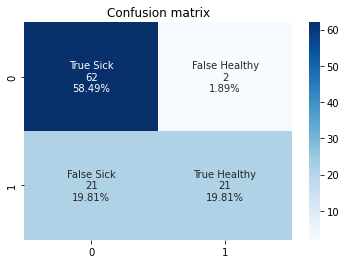

In [65]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(Xtrain, ytrain)

ytest_pred = rf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_names = ['True Sick','False Healthy','False Sick','True Healthy']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix")

print("Accuracy: {:.1f}".format(accuracy_score(ytest, ytest_pred)*100))
print("Sensibility: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))
print("Specificity: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))

### RF with the 3 categories

In [66]:
from sklearn.decomposition import PCA

data=pd.concat([data_healthy_2,data_fuchs,data_haze_2],ignore_index=True)
# data=pd.concat([data_healthy_2,data_fuchs])
# data=data_healthy
# data=pd.concat([data_healthy,data_haze])
# data
data_copy=data.drop(["Healthy","Origin"],axis=1)
data_copy=pd.DataFrame(np.real(data_copy))
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)

new_data=data_copy
new_data["Healthy"]=data["Healthy"]
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_data, test_size=0.2)

ytrain=train["Healthy"]
Xtrain=train.drop(["Healthy"],axis=1)

ytest=test["Healthy"]
Xtest=test.drop(["Healthy"],axis=1)

print("Total number of data:{:.0f} splited in train:{:.0f} and test:{:.0f}".format(len(data),len(ytrain),len(ytest)))
print("		Number of healthy in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==1),(np.sum(data["Healthy"]==1)/len(data["Healthy"]==1)*100),np.sum(ytrain==1),(np.sum(ytrain==1)/len(ytrain)*100),np.sum(ytest==1),(np.sum(ytest==1)/len(ytest)*100)))
print("		Number of haze    in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==0),(np.sum(data["Healthy"]==0)/len(data["Healthy"]==0)*100),np.sum(ytrain==0),(np.sum(ytrain==0)/len(ytrain)*100),np.sum(ytest==0),(np.sum(ytest==0)/len(ytest)*100)))
print("		Number of fuchs   in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==2),(np.sum(data["Healthy"]==2)/len(data["Healthy"]==2)*100),np.sum(ytrain==2),(np.sum(ytrain==2)/len(ytrain)*100),np.sum(ytest==2),(np.sum(ytest==2)/len(ytest)*100)))
# ytrain=(ytrain==1)*1
# ytest=(ytest==1)*1
# ytest["Healthy"]=(ytest["Healthy"]==1)*1
# new_data["Healthy"]=data["Healthy"]

Total number of data:527 splited in train:421 and test:106
		Number of healthy in   dataset:166 (31%) train:134 (32%) test:32 (30%)
		Number of haze    in   dataset:45 (9%) train:31 (7%) test:14 (13%)
		Number of fuchs   in   dataset:316 (60%) train:256 (61%) test:60 (57%)


Accuracy: 69.8%


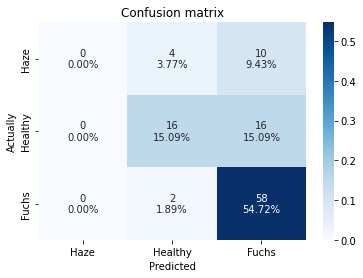

In [67]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(Xtrain, ytrain)

ytest_pred = rf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

p=sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='', cmap='Blues',annot=labels)
p.set(xticklabels=["Haze","Healthy","Fuchs"])
p.set(xlabel="Predicted")
p.set(yticklabels=["Haze","Healthy","Fuchs"])
p.set(ylabel="Actually")
plt.title("Confusion matrix")

print("Accuracy: {:.1f}%".format(accuracy_score(ytest, ytest_pred)*100))

Evolution of accuracy depending on the number of axis used:

In [68]:
axis=[]
acc=[]
for nb_axis in range(2,data_copy.shape[1],2):
	Xtrain=Xtrain_ref@(pca.components_[0:nb_axis]).T
	Xtest=Xtest_ref@(pca.components_[0:nb_axis]).T
	rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
	rf.fit(Xtrain, ytrain_ref)
	ytest_pred = rf.predict(Xtest)
	acc.append(100*accuracy_score(ytest_ref, ytest_pred))
	axis.append(nb_axis)

Text(0, 0.5, 'Accuracy')

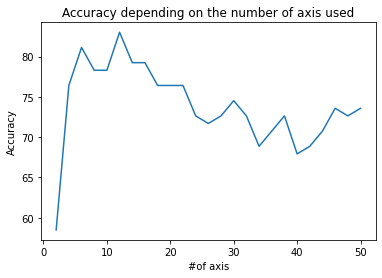

In [69]:
plt.plot(axis,acc)
plt.title("Accuracy depending on the number of axis used")
plt.xlabel("#of axis")
plt.ylabel("Accuracy")

## Test sur les extrémums locaux

Deuxième proche: travailler sur les fréquences fondamentales/harmoniques: on utilise les maximums locaux de la transformé de Fourier

In [70]:
def extract_sp(y):
    y = np.fft.fft(y)
    # y = np.fft.fft(im_Q.iProfileExpCorrection)
    dt=1
    y = dt*np.fft.fftshift(np.append(y,y[0]))
    n = y.size
    freq = np.fft.fftshift(np.fft.fftfreq(n, d=dt))
    y=y[n//2:];freq=freq[n//2:]
    fq=argrelextrema(y, np.greater)[0]
    # fq=fq[:N]
    return(freq[fq],y[fq])

def create_dataset_tf(repository,healthy_value,movingWin=False,eliminate=0,useExpCorr=False):
	files = [f for f in listdir(repository) if isfile(join(repository, f))]
	quantification=[]
	i=0
	i_list=[]
	for f in files:
		if(f[-3:]=="jpg"):
			i+=1
			try:
				im=image_OCT(os.path.join(repository, f))
			except:
				print("Error with: "+f+" image #"+str(i))
			try:
				im.AutoTreatment()
				im_Q=image_Quantification_3(im,movingWin=movingWin,eliminate=eliminate,useExpCorr=useExpCorr)
				fq,I=extract_sp(im_Q.iProfileCrop)
				# im_Q=image_Quantification_2(im,plot=False,intensity_corr=intensity_corr)
				parameters={
					"N":len(I),
					"fqFondam":fq[0],
					"IFondam":I[0],
					"fqSecond":fq[1],
					"ISecond":I[1],
					"fqThird":fq[1],
					"IThird":I[1],
				}
				parameters["Healthy"]=healthy_value
				parameters["Origin"]=f[:-4]
				quantification.append(parameters)
				# print(i,":",healthy)
				i_list.append(i)
			except:
				print("Error with: "+f+" image #"+str(i))
	n=len(quantification)
	print(n,"/",len(files)," files succesfully quantified")
	data=pd.DataFrame(quantification,index=range(n)) 
	return(data)


In [71]:
# Compute or import dataset
move=True
useExpCorr=False
# folder="exp_correction/"
# append="_mov_win-exp_corr_"
append=""
folder=""

try:
	data_healthy = pd.read_pickle("./Dataset/"+folder+"data_set_TF_healthy"+append+".pkl")
except:
	repertory_healthy=os.path.join(dirname, 'Data','Healthy')
	healthy_value=1 #healthy
	data_healthy=create_dataset_tf(repertory_healthy,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_healthy.to_pickle("./Dataset/data_set_TF_healthy"+append+".pkl")
 
try:
	data_healthy_2 = pd.read_pickle("./Dataset/"+folder+"data_set_TF_healthy_2"+append+".pkl")
except:
	repertory_healthy_2=os.path.join(dirname, 'Data','Healthy_2')
	healthy_value=1 #healthy
	data_healthy_2=create_dataset_tf(repertory_healthy_2,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_healthy_2.to_pickle("./Dataset/data_set_TF_healthy_2"+append+".pkl")
try:
	data_haze = pd.read_pickle("./Dataset/"+folder+"data_set_TF_haze"+append+".pkl")
except:
	repertory_haze=os.path.join(dirname, 'Data','HAZE')
	healthy_value=0 #patho
	data_haze=create_dataset_tf(repertory_haze,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_haze.to_pickle("./Dataset/data_set_TF_haze"+append+".pkl")

try:
	data_haze_2 = pd.read_pickle("./Dataset/"+folder+"data_set_TF_haze_2"+append+".pkl")
except:
	repertory_haze_2=os.path.join(dirname, 'Data','HAZE_2')
	healthy_value=0 #patho
	data_haze_2=create_dataset_tf(repertory_haze_2,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_haze_2.to_pickle("./Dataset/data_set_TF_haze_2"+append+".pkl")

try:
	data_fuchs = pd.read_pickle("./Dataset/"+folder+"data_set_TF_fuchs"+append+".pkl")
except:
	repertory_fuchs=os.path.join(dirname, 'Data','Fuchs_2')
	healthy_value=2 #fushs
	data_fuchs=create_dataset_tf(repertory_fuchs,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_fuchs.to_pickle("./Dataset/data_set_TF_fuchs"+append+".pkl")

try:
	data_fuchs_rep = pd.read_pickle("./Dataset/"+folder+"data_set_TF_fuchs_rep"+append+".pkl") 
except:
	repertory_fuchs_rep=os.path.join(dirname, 'Data','repetabilite_FuchsDMEK')
	healthy_value=2 #fushs
	data_fuchs_rep=create_dataset_tf(repertory_fuchs_rep,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_fuchs_rep.to_pickle("./Dataset/data_set_TF_fuchs_rep"+append+".pkl")

print("Succesfully imported")

Succesfully imported


In [72]:
from sklearn.decomposition import PCA

data=pd.concat([data_healthy_2,data_fuchs,data_haze_2],ignore_index=True)
# data=pd.concat([data_healthy_2,data_fuchs])
# data=data_healthy
# data=pd.concat([data_healthy,data_haze])
# data
data_copy=data.drop(["Healthy","Origin"],axis=1)
data_copy=pd.DataFrame(np.real(data_copy))
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)

new_data=data_copy
new_data["Healthy"]=data["Healthy"]
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_data, test_size=0.2)

ytrain=train["Healthy"]
Xtrain=train.drop(["Healthy"],axis=1)

ytest=test["Healthy"]
Xtest=test.drop(["Healthy"],axis=1)

print("Total number of data:{:.0f} splited in train:{:.0f} and test:{:.0f}".format(len(data),len(ytrain),len(ytest)))
print("		Number of healthy in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==1),(np.sum(data["Healthy"]==1)/len(data["Healthy"]==1)*100),np.sum(ytrain==1),(np.sum(ytrain==1)/len(ytrain)*100),np.sum(ytest==1),(np.sum(ytest==1)/len(ytest)*100)))
print("		Number of haze    in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==0),(np.sum(data["Healthy"]==0)/len(data["Healthy"]==0)*100),np.sum(ytrain==0),(np.sum(ytrain==0)/len(ytrain)*100),np.sum(ytest==0),(np.sum(ytest==0)/len(ytest)*100)))
print("		Number of fuchs   in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==2),(np.sum(data["Healthy"]==2)/len(data["Healthy"]==2)*100),np.sum(ytrain==2),(np.sum(ytrain==2)/len(ytrain)*100),np.sum(ytest==2),(np.sum(ytest==2)/len(ytest)*100)))
ytrain=(ytrain==1)*1
ytest=(ytest==1)*1
# ytest["Healthy"]=(ytest["Healthy"]==1)*1
# new_data["Healthy"]=data["Healthy"]

Total number of data:527 splited in train:421 and test:106
		Number of healthy in   dataset:166 (31%) train:131 (31%) test:35 (33%)
		Number of haze    in   dataset:45 (9%) train:38 (9%) test:7 (7%)
		Number of fuchs   in   dataset:316 (60%) train:252 (60%) test:64 (60%)


In [73]:
data_healthy.head()

,N,fqFondam,IFondam,fqSecond,ISecond,fqThird,IThird,Healthy,Origin
0,11,0.079208,1.926395-2.010609j,0.148515,1.352421-0.959605j,0.148515,1.352421-0.959605j,1,23923_BOULIS_OD
1,12,0.059406,2.234868-0.926770j,0.079208,1.573745-2.568835j,0.079208,1.573745-2.568835j,1,79296_BESNIC_OD
2,13,0.039604,0.825292-3.596141j,0.069307,1.958902-2.089227j,0.069307,1.958902-2.089227j,1,80552_CORANT_OD
3,9,0.069307,1.541572-1.360412j,0.148515,1.713022-0.250876j,0.148515,1.713022-0.250876j,1,80552_CORANT_OS
4,13,0.059406,1.497598-1.551116j,0.079208,1.705875-1.742904j,0.079208,1.705875-1.742904j,1,80553_DUMFAU_OD


### SVM

Accuracy: 66.0
Sensibility: 2.9
Specificity: 2.9


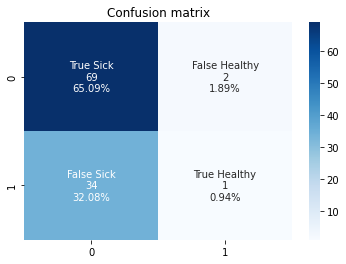

In [74]:
from sklearn import svm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = svm.SVC()
clf.fit(Xtrain, ytrain)
ytest_pred = clf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_names = ['True Sick','False Healthy','False Sick','True Healthy']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix")

print("Accuracy: {:.1f}".format(accuracy_score(ytest, ytest_pred)*100))
print("Sensibility: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))
print("Specificity: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))

### RF

Accuracy: 67.0
Sensibility: 20.0
Specificity: 20.0


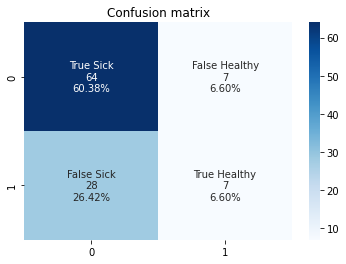

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(Xtrain, ytrain)

ytest_pred = rf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_names = ['True Sick','False Healthy','False Sick','True Healthy']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix")

print("Accuracy: {:.1f}".format(accuracy_score(ytest, ytest_pred)*100))
print("Sensibility: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))
print("Specificity: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))

### RF with the 3 categories

In [76]:
from sklearn.decomposition import PCA

data=pd.concat([data_healthy_2,data_fuchs,data_haze_2],ignore_index=True)
# data=pd.concat([data_healthy_2,data_fuchs])
# data=data_healthy
# data=pd.concat([data_healthy,data_haze])
# data
data_copy=data.drop(["Healthy","Origin"],axis=1)
data_copy=pd.DataFrame(np.real(data_copy))
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)

new_data=data_copy
new_data["Healthy"]=data["Healthy"]
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_data, test_size=0.2)

ytrain=train["Healthy"]
Xtrain=train.drop(["Healthy"],axis=1)

ytest=test["Healthy"]
Xtest=test.drop(["Healthy"],axis=1)

print("Total number of data:{:.0f} splited in train:{:.0f} and test:{:.0f}".format(len(data),len(ytrain),len(ytest)))
print("		Number of healthy in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==1),(np.sum(data["Healthy"]==1)/len(data["Healthy"]==1)*100),np.sum(ytrain==1),(np.sum(ytrain==1)/len(ytrain)*100),np.sum(ytest==1),(np.sum(ytest==1)/len(ytest)*100)))
print("		Number of haze    in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==0),(np.sum(data["Healthy"]==0)/len(data["Healthy"]==0)*100),np.sum(ytrain==0),(np.sum(ytrain==0)/len(ytrain)*100),np.sum(ytest==0),(np.sum(ytest==0)/len(ytest)*100)))
print("		Number of fuchs   in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==2),(np.sum(data["Healthy"]==2)/len(data["Healthy"]==2)*100),np.sum(ytrain==2),(np.sum(ytrain==2)/len(ytrain)*100),np.sum(ytest==2),(np.sum(ytest==2)/len(ytest)*100)))
# ytrain=(ytrain==1)*1
# ytest=(ytest==1)*1
# ytest["Healthy"]=(ytest["Healthy"]==1)*1
# new_data["Healthy"]=data["Healthy"]

Total number of data:527 splited in train:421 and test:106
		Number of healthy in   dataset:166 (31%) train:135 (32%) test:31 (29%)
		Number of haze    in   dataset:45 (9%) train:35 (8%) test:10 (9%)
		Number of fuchs   in   dataset:316 (60%) train:251 (60%) test:65 (61%)


Accuracy: 69.8%


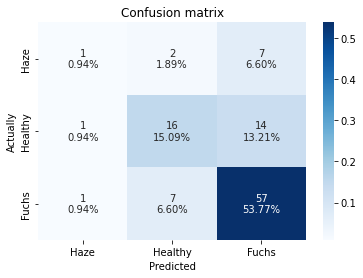

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(Xtrain, ytrain)

ytest_pred = rf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

p=sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='', cmap='Blues',annot=labels)
p.set(xticklabels=["Haze","Healthy","Fuchs"])
p.set(xlabel="Predicted")
p.set(yticklabels=["Haze","Healthy","Fuchs"])
p.set(ylabel="Actually")
plt.title("Confusion matrix")

print("Accuracy: {:.1f}%".format(accuracy_score(ytest, ytest_pred)*100))

## With classical quatifier (Q3)

On utilise les paramètres quantifié par nos approches classiques en l'occurence la version 3

In [78]:
# Compute or import dataset
move=True
useExpCorr=False
# folder="exp_correction/"
# append="_mov_win-exp_corr_"
append="_mov_win_"
folder=""

try:
	data_healthy = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_healthy"+append+".pkl")
except:
	repertory_healthy=os.path.join(dirname, 'Data','Healthy')
	healthy_value=1 #healthy
	data_healthy=create_new_dataset(repertory_healthy,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_healthy.to_pickle("./Dataset/data_set_Q3_healthy"+append+".pkl")
 
try:
	data_healthy_2 = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_healthy_2"+append+".pkl")
except:
	repertory_healthy_2=os.path.join(dirname, 'Data','Healthy_2')
	healthy_value=1 #healthy
	data_healthy_2=create_new_dataset(repertory_healthy_2,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_healthy_2.to_pickle("./Dataset/data_set_Q3_healthy_2"+append+".pkl")
try:
	data_haze = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_haze"+append+".pkl")
except:
	repertory_haze=os.path.join(dirname, 'Data','HAZE')
	healthy_value=0 #patho
	data_haze=create_new_dataset(repertory_haze,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_haze.to_pickle("./Dataset/data_set_Q3_haze"+append+".pkl")

try:
	data_haze_2 = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_haze_2"+append+".pkl")
except:
	repertory_haze_2=os.path.join(dirname, 'Data','HAZE_2')
	healthy_value=0 #patho
	data_haze_2=create_new_dataset(repertory_haze_2,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_haze_2.to_pickle("./Dataset/data_set_Q3_haze_2"+append+".pkl")

try:
	data_fuchs = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_fuchs"+append+".pkl")
except:
	repertory_fuchs=os.path.join(dirname, 'Data','Fuchs_2')
	healthy_value=2 #fushs
	data_fuchs=create_new_dataset(repertory_fuchs,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_fuchs.to_pickle("./Dataset/data_set_Q3_fuchs"+append+".pkl")

try:
	data_fuchs_rep = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_fuchs_rep"+append+".pkl") 
except:
	repertory_fuchs_rep=os.path.join(dirname, 'Data','repetabilite_FuchsDMEK')
	healthy_value=2 #fushs
	data_fuchs_rep=create_new_dataset(repertory_fuchs_rep,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_fuchs_rep.to_pickle("./Dataset/data_set_Q3_fuchs_rep"+append+".pkl")

print("Succesfully imported")

Succesfully imported


In [79]:
from sklearn.decomposition import PCA

data=pd.concat([data_healthy_2,data_fuchs,data_haze_2],ignore_index=True)
# data=pd.concat([data_healthy_2,data_fuchs])
# data=data_healthy
# data=pd.concat([data_healthy,data_haze])
# data
data_copy=data.drop(["Healthy","Origin"],axis=1)
data_copy=pd.DataFrame(np.real(data_copy))
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)

new_data=data_copy
new_data["Healthy"]=data["Healthy"]
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_data, test_size=0.2)

ytrain=train["Healthy"]
Xtrain=train.drop(["Healthy"],axis=1)

ytest=test["Healthy"]
Xtest=test.drop(["Healthy"],axis=1)

print("Total number of data:{:.0f} splited in train:{:.0f} and test:{:.0f}".format(len(data),len(ytrain),len(ytest)))
print("		Number of healthy in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==1),(np.sum(data["Healthy"]==1)/len(data["Healthy"]==1)*100),np.sum(ytrain==1),(np.sum(ytrain==1)/len(ytrain)*100),np.sum(ytest==1),(np.sum(ytest==1)/len(ytest)*100)))
print("		Number of haze    in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==0),(np.sum(data["Healthy"]==0)/len(data["Healthy"]==0)*100),np.sum(ytrain==0),(np.sum(ytrain==0)/len(ytrain)*100),np.sum(ytest==0),(np.sum(ytest==0)/len(ytest)*100)))
print("		Number of fuchs   in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==2),(np.sum(data["Healthy"]==2)/len(data["Healthy"]==2)*100),np.sum(ytrain==2),(np.sum(ytrain==2)/len(ytrain)*100),np.sum(ytest==2),(np.sum(ytest==2)/len(ytest)*100)))
ytrain=(ytrain==1)*1
ytest=(ytest==1)*1
# ytest["Healthy"]=(ytest["Healthy"]==1)*1
# new_data["Healthy"]=data["Healthy"]

Total number of data:527 splited in train:421 and test:106
		Number of healthy in   dataset:166 (31%) train:130 (31%) test:36 (34%)
		Number of haze    in   dataset:45 (9%) train:38 (9%) test:7 (7%)
		Number of fuchs   in   dataset:316 (60%) train:253 (60%) test:63 (59%)


### SVM

Accuracy: 66.0
Sensibility: 0.0
Specificity: 0.0


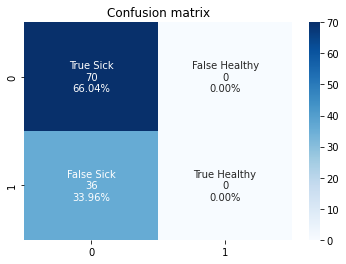

In [80]:
from sklearn import svm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = svm.SVC()
clf.fit(Xtrain, ytrain)
ytest_pred = clf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_names = ['True Sick','False Healthy','False Sick','True Healthy']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix")

print("Accuracy: {:.1f}".format(accuracy_score(ytest, ytest_pred)*100))
print("Sensibility: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))
print("Specificity: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))

### RF

Accuracy: 93.4
Sensibility: 86.1
Specificity: 86.1


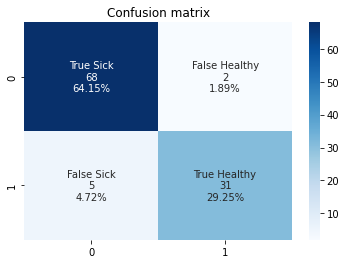

In [81]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(Xtrain, ytrain)

ytest_pred = rf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_names = ['True Sick','False Healthy','False Sick','True Healthy']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix")

print("Accuracy: {:.1f}".format(accuracy_score(ytest, ytest_pred)*100))
print("Sensibility: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))
print("Specificity: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))

### RF with the 3 categories

In [82]:
from sklearn.decomposition import PCA

data=pd.concat([data_healthy_2,data_fuchs,data_haze_2],ignore_index=True)
# data=pd.concat([data_healthy_2,data_fuchs])
# data=data_healthy
# data=pd.concat([data_healthy,data_haze])
# data
data_copy=data.drop(["Healthy","Origin"],axis=1)
data_copy=pd.DataFrame(np.real(data_copy))
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)

new_data=data_copy
new_data["Healthy"]=data["Healthy"]
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_data, test_size=0.2)

ytrain=train["Healthy"]
Xtrain=train.drop(["Healthy"],axis=1)

ytest=test["Healthy"]
Xtest=test.drop(["Healthy"],axis=1)

print("Total number of data:{:.0f} splited in train:{:.0f} and test:{:.0f}".format(len(data),len(ytrain),len(ytest)))
print("		Number of healthy in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==1),(np.sum(data["Healthy"]==1)/len(data["Healthy"]==1)*100),np.sum(ytrain==1),(np.sum(ytrain==1)/len(ytrain)*100),np.sum(ytest==1),(np.sum(ytest==1)/len(ytest)*100)))
print("		Number of haze    in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==0),(np.sum(data["Healthy"]==0)/len(data["Healthy"]==0)*100),np.sum(ytrain==0),(np.sum(ytrain==0)/len(ytrain)*100),np.sum(ytest==0),(np.sum(ytest==0)/len(ytest)*100)))
print("		Number of fuchs   in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==2),(np.sum(data["Healthy"]==2)/len(data["Healthy"]==2)*100),np.sum(ytrain==2),(np.sum(ytrain==2)/len(ytrain)*100),np.sum(ytest==2),(np.sum(ytest==2)/len(ytest)*100)))
# ytrain=(ytrain==1)*1
# ytest=(ytest==1)*1
# ytest["Healthy"]=(ytest["Healthy"]==1)*1
# new_data["Healthy"]=data["Healthy"]

Total number of data:527 splited in train:421 and test:106
		Number of healthy in   dataset:166 (31%) train:125 (30%) test:41 (39%)
		Number of haze    in   dataset:45 (9%) train:35 (8%) test:10 (9%)
		Number of fuchs   in   dataset:316 (60%) train:261 (62%) test:55 (52%)


Accuracy: 93.4%


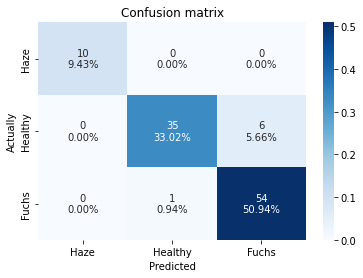

In [83]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(Xtrain, ytrain)

ytest_pred = rf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

p=sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='', cmap='Blues',annot=labels)
p.set(xticklabels=["Haze","Healthy","Fuchs"])
p.set(xlabel="Predicted")
p.set(yticklabels=["Haze","Healthy","Fuchs"])
p.set(ylabel="Actually")
plt.title("Confusion matrix")

print("Accuracy: {:.1f}%".format(accuracy_score(ytest, ytest_pred)*100))

## With classical quantifier (Q1)

On utilise les paramètres quantifié par nos approches classiques en l'occurence la version 1

In [84]:
# Compute or import dataset
# folder="exp_correction/"
# append="_mov_win-exp_corr_"
append=""
folder=""

try:
	data_healthy_2 = pd.read_pickle("./Dataset/"+folder+"data_set_Q1_healthy_2"+append+".pkl")
	data_haze_2 = pd.read_pickle("./Dataset/"+folder+"data_set_Q1_haze_2"+append+".pkl")
	data_fuchs = pd.read_pickle("./Dataset/"+folder+"data_set_Q1_fuchs"+append+".pkl")
	data_fuchs_rep = pd.read_pickle("./Dataset/"+folder+"data_set_Q1_fuchs_rep"+append+".pkl") 
	print("Succesfully imported")
except:
	print("not created")

Succesfully imported


In [85]:
from sklearn.decomposition import PCA

data=pd.concat([data_healthy_2,data_fuchs,data_haze_2],ignore_index=True)
# data=pd.concat([data_healthy_2,data_fuchs])
# data=data_healthy
# data=pd.concat([data_healthy,data_haze])
# data
data_copy=data.drop(["Healthy","Origin","Month"],axis=1)
# data_copy=pd.DataFrame(np.real(data_copy))
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)

new_data=data_copy
new_data["Healthy"]=data["Healthy"]
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_data, test_size=0.2)

ytrain=train["Healthy"]
Xtrain=train.drop(["Healthy"],axis=1)

ytest=test["Healthy"]
Xtest=test.drop(["Healthy"],axis=1)

print("Total number of data:{:.0f} splited in train:{:.0f} and test:{:.0f}".format(len(data),len(ytrain),len(ytest)))
print("		Number of healthy in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==1),(np.sum(data["Healthy"]==1)/len(data["Healthy"]==1)*100),np.sum(ytrain==1),(np.sum(ytrain==1)/len(ytrain)*100),np.sum(ytest==1),(np.sum(ytest==1)/len(ytest)*100)))
print("		Number of haze    in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==0),(np.sum(data["Healthy"]==0)/len(data["Healthy"]==0)*100),np.sum(ytrain==0),(np.sum(ytrain==0)/len(ytrain)*100),np.sum(ytest==0),(np.sum(ytest==0)/len(ytest)*100)))
print("		Number of fuchs   in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==2),(np.sum(data["Healthy"]==2)/len(data["Healthy"]==2)*100),np.sum(ytrain==2),(np.sum(ytrain==2)/len(ytrain)*100),np.sum(ytest==2),(np.sum(ytest==2)/len(ytest)*100)))
ytrain=(ytrain==1)*1
ytest=(ytest==1)*1
# ytest["Healthy"]=(ytest["Healthy"]==1)*1
# new_data["Healthy"]=data["Healthy"]

Total number of data:456 splited in train:364 and test:92
		Number of healthy in   dataset:145 (32%) train:119 (33%) test:26 (28%)
		Number of haze    in   dataset:29 (6%) train:24 (7%) test:5 (5%)
		Number of fuchs   in   dataset:282 (62%) train:221 (61%) test:61 (66%)


Accuracy: 89.1
Sensibility: 73.1
Specificity: 73.1


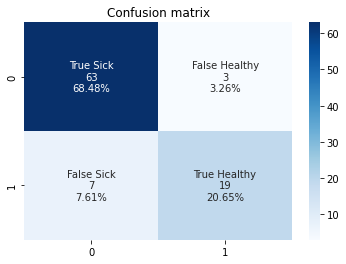

In [86]:
from sklearn import svm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = svm.SVC()
clf.fit(Xtrain, ytrain)
ytest_pred = clf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_names = ['True Sick','False Healthy','False Sick','True Healthy']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix")

print("Accuracy: {:.1f}".format(accuracy_score(ytest, ytest_pred)*100))
print("Sensibility: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))
print("Specificity: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))

Accuracy: 91.3
Sensibility: 80.8
Specificity: 80.8


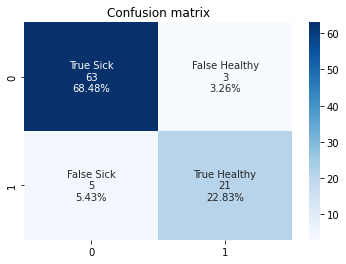

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(Xtrain, ytrain)

ytest_pred = rf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_names = ['True Sick','False Healthy','False Sick','True Healthy']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion matrix")

print("Accuracy: {:.1f}".format(accuracy_score(ytest, ytest_pred)*100))
print("Sensibility: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))
print("Specificity: {:.1f}".format(cf_matrix[1,1]/(np.sum(cf_matrix[1,:])) *100))

### RF with the 3 categories

In [88]:
from sklearn.decomposition import PCA

data=pd.concat([data_healthy_2,data_fuchs,data_haze_2],ignore_index=True)
# data=pd.concat([data_healthy_2,data_fuchs])
# data=data_healthy
# data=pd.concat([data_healthy,data_haze])
# data
data_copy=data.drop(["Healthy","Origin","Month"],axis=1)
data_copy=pd.DataFrame(np.real(data_copy))
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)

new_data=data_copy
new_data["Healthy"]=data["Healthy"]
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_data, test_size=0.2)

ytrain=train["Healthy"]
Xtrain=train.drop(["Healthy"],axis=1)

ytest=test["Healthy"]
Xtest=test.drop(["Healthy"],axis=1)

print("Total number of data:{:.0f} splited in train:{:.0f} and test:{:.0f}".format(len(data),len(ytrain),len(ytest)))
print("		Number of healthy in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==1),(np.sum(data["Healthy"]==1)/len(data["Healthy"]==1)*100),np.sum(ytrain==1),(np.sum(ytrain==1)/len(ytrain)*100),np.sum(ytest==1),(np.sum(ytest==1)/len(ytest)*100)))
print("		Number of haze    in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==0),(np.sum(data["Healthy"]==0)/len(data["Healthy"]==0)*100),np.sum(ytrain==0),(np.sum(ytrain==0)/len(ytrain)*100),np.sum(ytest==0),(np.sum(ytest==0)/len(ytest)*100)))
print("		Number of fuchs   in   dataset:{:.0f} ({:.0f}%) train:{:.0f} ({:.0f}%) test:{:.0f} ({:.0f}%)".format(np.sum(data["Healthy"]==2),(np.sum(data["Healthy"]==2)/len(data["Healthy"]==2)*100),np.sum(ytrain==2),(np.sum(ytrain==2)/len(ytrain)*100),np.sum(ytest==2),(np.sum(ytest==2)/len(ytest)*100)))
# ytrain=(ytrain==1)*1
# ytest=(ytest==1)*1
# ytest["Healthy"]=(ytest["Healthy"]==1)*1
# new_data["Healthy"]=data["Healthy"]

Total number of data:456 splited in train:364 and test:92
		Number of healthy in   dataset:145 (32%) train:119 (33%) test:26 (28%)
		Number of haze    in   dataset:29 (6%) train:21 (6%) test:8 (9%)
		Number of fuchs   in   dataset:282 (62%) train:224 (62%) test:58 (63%)


Accuracy: 80.4%


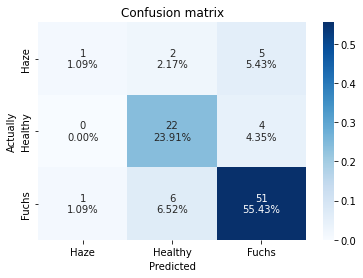

In [89]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(Xtrain, ytrain)

ytest_pred = rf.predict(Xtest)

cf_matrix=confusion_matrix(ytest, ytest_pred)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

p=sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='', cmap='Blues',annot=labels)
p.set(xticklabels=["Haze","Healthy","Fuchs"])
p.set(xlabel="Predicted")
p.set(yticklabels=["Haze","Healthy","Fuchs"])
p.set(ylabel="Actually")
plt.title("Confusion matrix")

print("Accuracy: {:.1f}%".format(accuracy_score(ytest, ytest_pred)*100))